In [1]:
import glob
from datetime import datetime
import zipfile
import os
import re
import gzip

import pandas as pd
import dask.dataframe as dd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
def get_dataframe_from_zip(filename, date_parser):
    z = zipfile.ZipFile(filename)
    namelist = z.namelist()
    datafile = [x for x in namelist if x.startswith('produkt_')][0]
    df = pd.read_csv(z.open(datafile), delimiter=';', na_values=['', '-999'],
                     skip_blank_lines=True, skipinitialspace=True,
                     parse_dates=[1], date_parser=date_parser)
    df = df.rename(columns={x: x.strip() for x in df.columns})
    df = df[~df['MESS_DATUM'].isnull()]
    df['STATIONS_ID'] = pd.to_numeric(df['STATIONS_ID'], errors='raise')
    return df


def load_all_zips(pattern, date_parser):
    all_zips = glob.glob(pattern)
    zip_count = len(all_zips)
    for i, filename in enumerate(all_zips):
        print(filename)
        print('%d/%d - %2.f%%' % (i, zip_count, i / zip_count * 100.0), end="\r")
        try:
            yield get_dataframe_from_zip(filename, date_parser) 
        except zipfile.BadZipFile:
            print('%s is bad zip file, breaking!' % filename)
            break


def get_dataframe(filename, pattern, date_parser):
    if os.path.exists(filename):
        df = pd.read_csv(filename, compression='gzip', parse_dates=['MESS_DATUM'])
        return df
    df = pd.concat(load_all_zips(pattern, date_parser))
    with gzip.open(filename, 'wt') as write_file:
        df.to_csv(write_file, encoding='utf-8')
    return df

df = get_dataframe('data_hourly.csv.gz', 'data_hourly/*_20141231_hist.zip', lambda x: pd.to_datetime(x, format='%Y%m%d%H'))
df.head()

,Unnamed: 0,STATIONS_ID,MESS_DATUM,QUALITAETS_NIVEAU,NIEDERSCHLAG_GEFALLEN_IND,NIEDERSCHLAGSHOEHE,NIEDERSCHLAGSFORM,eor
0,0,20,2004-08-14 07:00:00,1.0,1.0,0.2,6.0,eor
1,1,20,2004-08-14 08:00:00,1.0,1.0,0.3,6.0,eor
2,2,20,2004-08-14 09:00:00,1.0,1.0,1.0,NaN,eor
3,3,20,2004-08-14 10:00:00,1.0,1.0,2.4,6.0,eor
4,4,20,2004-08-14 11:00:00,1.0,1.0,2.1,6.0,eor


In [3]:
SEP = re.compile('\s+')

def parse_stations(filename):
    header = None
    with open(filename, encoding='latin1') as f:
        for line in f:
            line = line.strip()
            if header is None:
                header = SEP.split(line)
                continue
            if line.startswith('-') or len(line) < 2:
                continue
            parts = SEP.split(line)
            if len(parts) > len(header):
                parts = parts[:6] + [' '.join(parts[6:-1])] + parts[-1:]
                assert(len(parts) == len(header))
            yield {k: v for k, v in zip(header, parts)}
                

stations = pd.DataFrame(parse_stations('data_hourly/RR_Stundenwerte_Beschreibung_Stationen.txt'))
stations['sid'] = pd.to_numeric(stations['Stations_id'], errors='coerce')
stations['lat'] = pd.to_numeric(stations['geoBreite'], errors='coerce')
stations['lng'] = pd.to_numeric(stations['geoLaenge'], errors='coerce')
stations['height'] = pd.to_numeric(stations['Stationshoehe'], errors='coerce')
stations['von_datum'] = pd.to_datetime(stations['von_datum'], format='%Y%m%d')
stations['bis_datum'] = pd.to_datetime(stations['bis_datum'], format='%Y%m%d')
stations.head()

,Bundesland,Stations_id,Stationshoehe,Stationsname,bis_datum,geoBreite,geoLaenge,von_datum,sid,lat,lng,height
0,Nordrhein-Westfalen,00003,202,Aachen,2011-04-01,50.7827,6.0941,1950-04-01,3,50.7827,6.0941,202
1,Baden-Württemberg,00011,680,Donaueschingen (Landeplatz),2016-03-05,47.9737,8.5205,2009-01-01,11,47.9737,8.5205,680
2,Baden-Württemberg,00020,432,Abtsgmünd-Untergröningen,2016-03-05,48.9220,9.9129,2004-08-13,20,48.9220,9.9129,432
3,Bayern,00029,260,Adelsdorf (Kläranlage),2016-03-05,49.7175,10.9101,2006-01-10,29,49.7175,10.9101,260
4,Niedersachsen,00044,44,Großenkneten,2016-03-05,52.9335,8.2370,1979-01-01,44,52.9335,8.2370,44


In [4]:
from mpl_toolkits.basemap import Basemap

germany_bbox = {
  'lon': 10.45415,
  'lat': 51.164181,
  'll_lon': 5.86624,
  'll_lat': 47.27021,
  'ur_lon': 15.04205,
  'ur_lat': 55.05814
}

def shifted_color_map(cmap, start=0, midpoint=0.5, stop=1.0, name='shiftedcmap'):
    '''
    Function to offset the "center" of a colormap. Useful for
    data with a negative min and positive max and you want the
    middle of the colormap's dynamic range to be at zero

    Input
    -----
      cmap : The matplotlib colormap to be altered
      start : Offset from lowest point in the colormap's range.
          Defaults to 0.0 (no lower ofset). Should be between
          0.0 and `midpoint`.
      midpoint : The new center of the colormap. Defaults to 
          0.5 (no shift). Should be between 0.0 and 1.0. In
          general, this should be  1 - vmax/(vmax + abs(vmin))
          For example if your data range from -15.0 to +5.0 and
          you want the center of the colormap at 0.0, `midpoint`
          should be set to  1 - 5/(5 + 15)) or 0.75
      stop : Offset from highets point in the colormap's range.
          Defaults to 1.0 (no upper ofset). Should be between
          `midpoint` and 1.0.
    '''
    cdict = {
        'red': [],
        'green': [],
        'blue': [],
        'alpha': []
    }

    # regular index to compute the colors
    reg_index = np.linspace(start, stop, 257)

    # shifted index to match the data
    shift_index = np.hstack([
        np.linspace(0.0, midpoint, 128, endpoint=False), 
        np.linspace(midpoint, 1.0, 129, endpoint=True)
    ])

    for ri, si in zip(reg_index, shift_index):
        r, g, b, a = cmap(ri)

        cdict['red'].append((si, r, r))
        cdict['green'].append((si, g, g))
        cdict['blue'].append((si, b, b))
        cdict['alpha'].append((si, a, a))

    newcmap = matplotlib.colors.LinearSegmentedColormap(name, cdict)
    plt.register_cmap(cmap=newcmap)

    return newcmap

def plot_map(df, vals='value', cmap='cool', diverging=False, bbox=germany_bbox):
    if diverging:
        vmin = df[vals].min()
        vmax = df[vals].max()
        midrange = 1 - vmax / (vmax + abs(vmin))
        cmap = shifted_color_map(matplotlib.cm.get_cmap(cmap), midpoint=midrange)
        
    markersize = 40
    markertype = 'o'  # pixel
    markercolor = '#325CA9'  # blue
    if vals is not None:
        markercolor = df[vals].as_matrix()
    markeralpha = .5 #  a bit of transparency

    fig = plt.figure(figsize=(10,16))
    m = Basemap(
      projection='mill', lon_0=bbox['lon'], lat_0=bbox['lat'],
      llcrnrlon=bbox['ll_lon'], llcrnrlat=bbox['ll_lat'],
      urcrnrlon=bbox['ur_lon'], urcrnrlat=bbox['ur_lat'],
      resolution='l'
    )
    m.drawmapboundary(fill_color='#ffffff', linewidth=.0)
    x, y = m(df.lng.as_matrix(), df.lat.as_matrix())
    m.drawcoastlines()
    m.drawcountries()
    m.scatter(x, y, markersize, marker=markertype,  cmap=cmap, c=markercolor, alpha=markeralpha)
    m.colorbar()
    return m


/Users/sw/.virtualenvs/notebook3/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


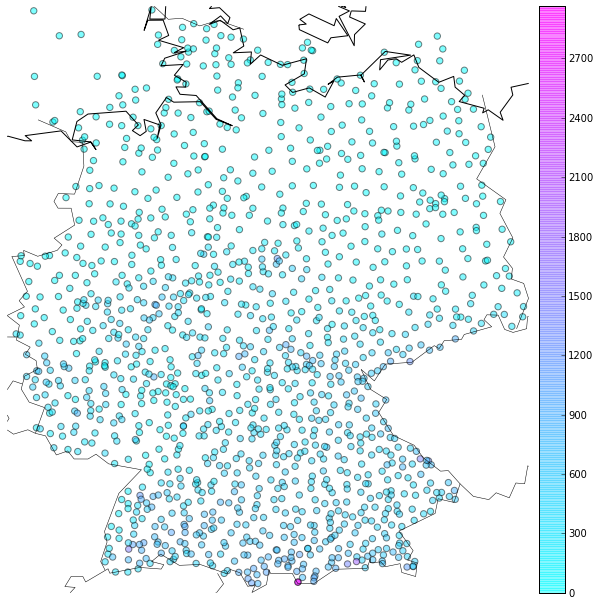

In [5]:
plot_map(stations, 'height')

/Users/sw/.virtualenvs/notebook3/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


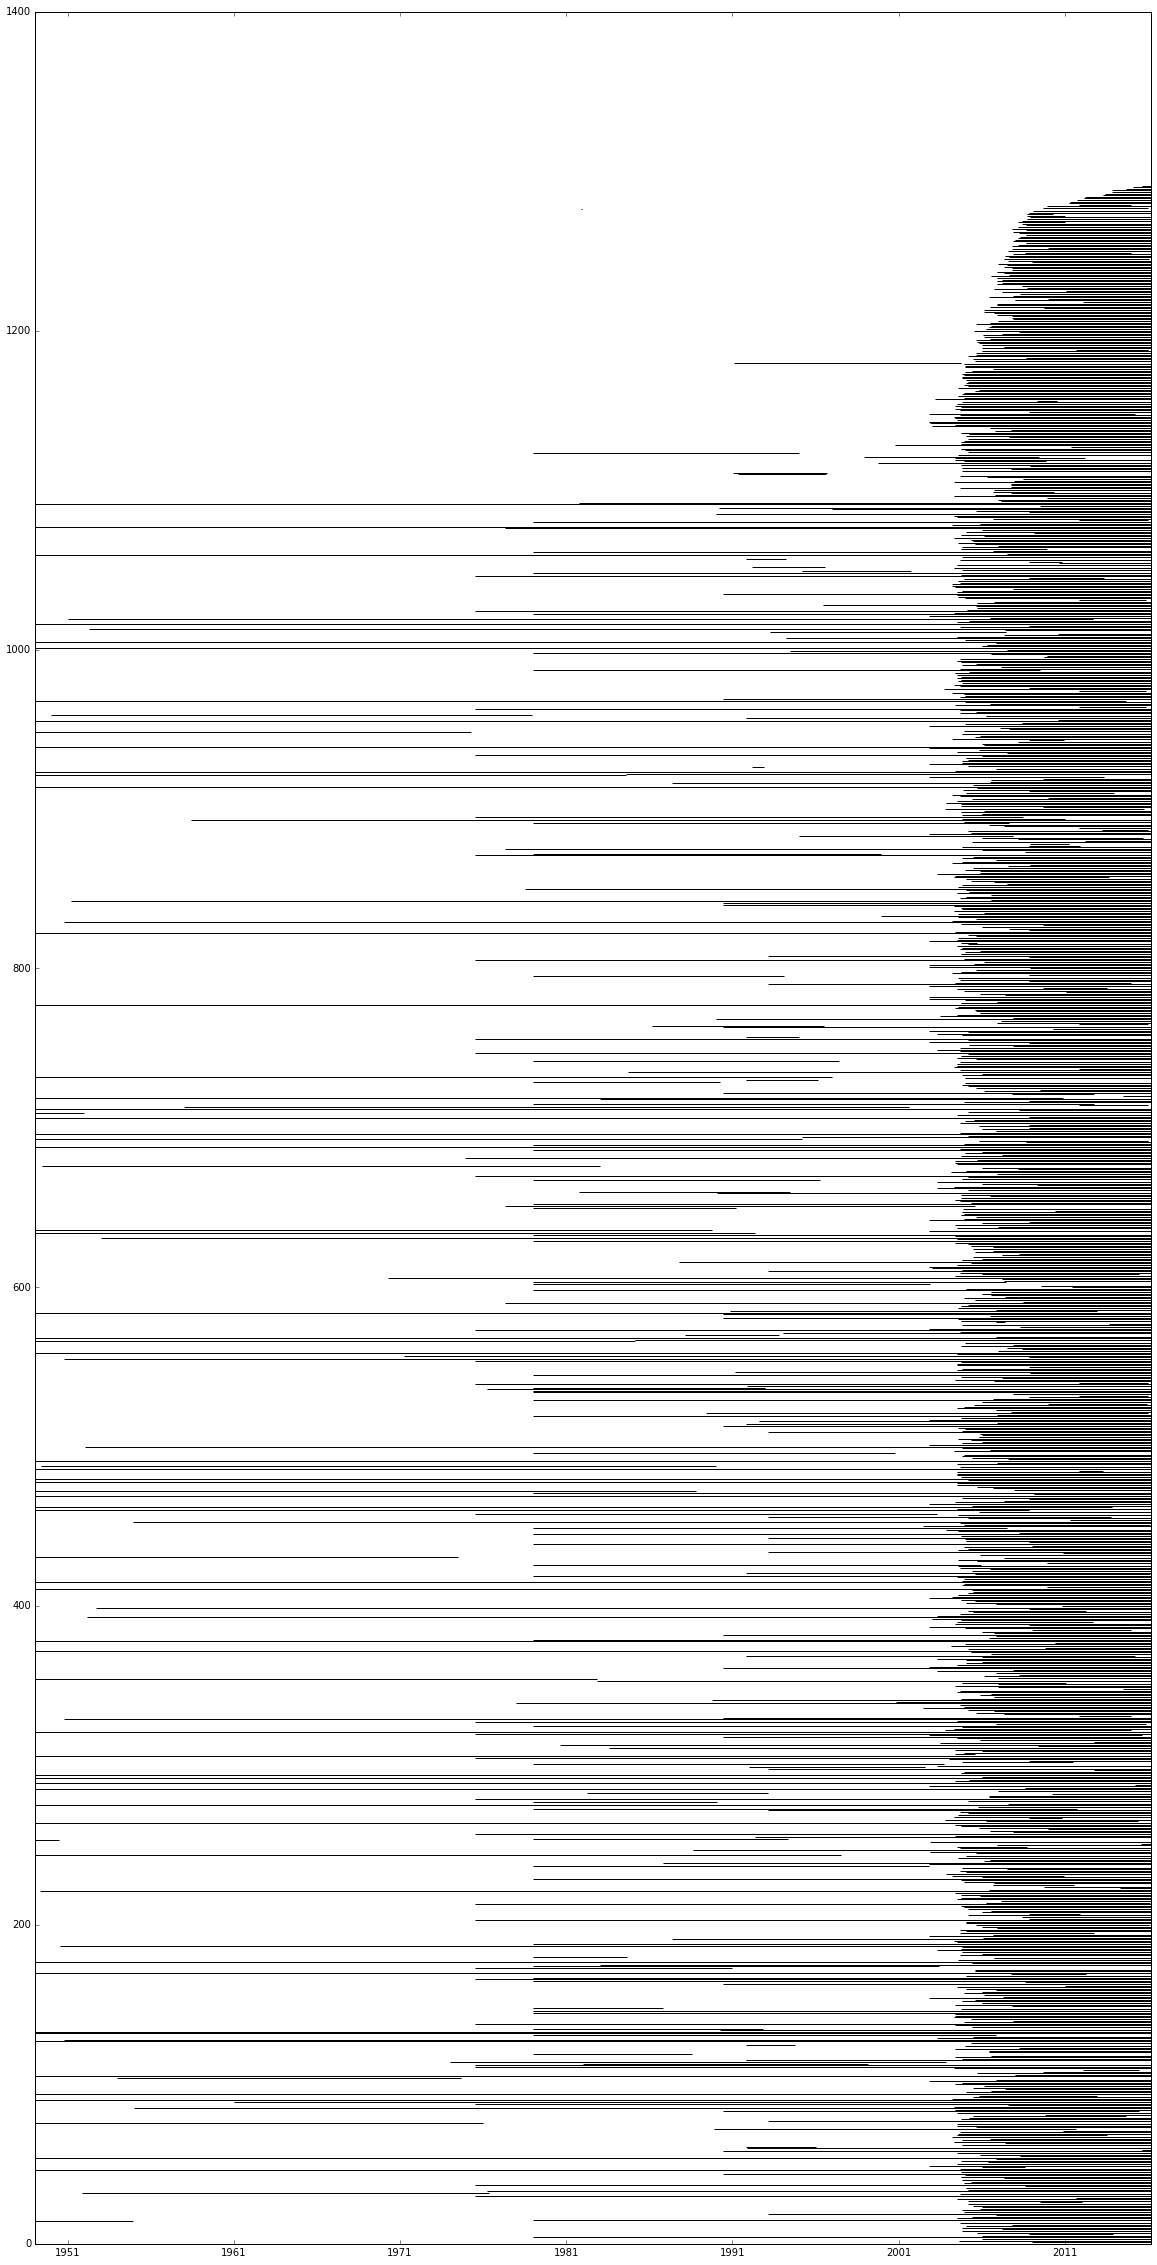

In [6]:
import matplotlib.dates as dt

fig = plt.figure(figsize=(20, 40))
ax = fig.add_subplot(111)
ax = ax.xaxis_date()
ax = plt.hlines(stations.index, dt.date2num(stations.von_datum.astype(datetime)), dt.date2num(stations.bis_datum.astype(datetime)))

In [7]:
constant_stations = stations[(stations.von_datum <= datetime(1992, 1, 1)) & (stations.bis_datum >= datetime(2015, 1, 1))]

In [8]:
stations[stations.Stationsname.str.contains('Münster')]

,Bundesland,Stations_id,Stationshoehe,Stationsname,bis_datum,geoBreite,geoLaenge,von_datum,sid,lat,lng,height
341,Nordrhein-Westfalen,01766,48,Münster/Osnabrück,2016-03-05,52.1344,7.6969,1989-10-01,1766,52.1344,7.6969,48
636,Nordrhein-Westfalen,03404,62,Münster,1989-10-02,51.9494,7.5906,1949-01-01,3404,51.9494,7.5906,62


In [9]:
df['NIEDERSCHLAGSHOEHE'].describe()

count    8.853889e+07
mean     8.955135e-02
std      5.405368e-01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      9.980000e+01
Name: NIEDERSCHLAGSHOEHE, dtype: float64

In [10]:
df_complete = df[df.STATIONS_ID.isin(constant_stations.sid)]
df_complete

,Unnamed: 0,STATIONS_ID,MESS_DATUM,QUALITAETS_NIVEAU,NIEDERSCHLAG_GEFALLEN_IND,NIEDERSCHLAGSHOEHE,NIEDERSCHLAGSFORM,eor
90844,0,44,2007-04-01 00:00:00,3.0,0.0,0.0,NaN,eor
90845,1,44,2007-04-01 01:00:00,3.0,0.0,0.0,0.0,eor
90846,2,44,2007-04-01 02:00:00,3.0,0.0,0.0,0.0,eor
90847,3,44,2007-04-01 03:00:00,3.0,0.0,0.0,NaN,eor
90848,4,44,2007-04-01 04:00:00,3.0,0.0,0.0,0.0,eor
90849,5,44,2007-04-01 05:00:00,3.0,0.0,0.0,0.0,eor
90850,6,44,2007-04-01 06:00:00,3.0,0.0,0.0,NaN,eor
90851,7,44,2007-04-01 07:00:00,3.0,0.0,0.0,0.0,eor
90852,8,44,2007-04-01 08:00:00,3.0,0.0,0.0,0.0,eor
90853,9,44,2007-04-01 09:00:00,3.0,0.0,0.0,NaN,eor


In [11]:
df_stations = df_complete.groupby(['MESS_DATUM', 'STATIONS_ID']).NIEDERSCHLAGSHOEHE.sum().unstack()
df_stations.tail()

STATIONS_ID,44,164,183,198,222,232,282,298,303,403,...,5490,5546,5629,5705,5779,5800,5839,5871,5906,5930
MESS_DATUM,,,,,,,,,,,,,,,,,,,,,
2014-12-31 19:00:00,0.0,0.0,0.0,0.0,0.1,0.0,0.1,0.0,0.2,0.0,...,0.0,0.0,0.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2014-12-31 20:00:00,0.0,0.1,0.0,0.2,0.3,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.1,0.1,0.0,0.0,0.0,0.0,0.0
2014-12-31 21:00:00,0.0,0.0,0.0,0.0,0.3,0.0,0.1,0.0,0.0,0.0,...,0.0,0.0,0.0,0.1,0.3,0.0,0.0,0.0,0.0,0.0
2014-12-31 22:00:00,0.0,0.1,0.0,0.0,0.1,0.0,0.2,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.2,0.0,0.0,0.0,0.0,0.0
2014-12-31 23:00:00,0.0,0.0,0.0,0.0,0.2,0.0,0.1,0.0,0.0,0.0,...,0.0,0.0,0.0,0.2,0.1,0.1,0.0,0.0,0.0,0.0


In [12]:
stations_99th_hourly = df_stations.resample('1A').apply(lambda x: x.quantile(0.99))

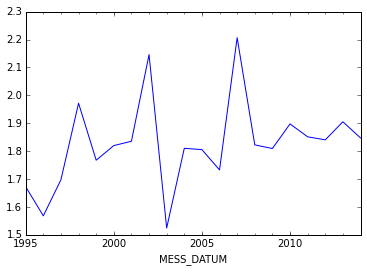

In [13]:
stations_99th_hourly.mean(axis=1).plot()

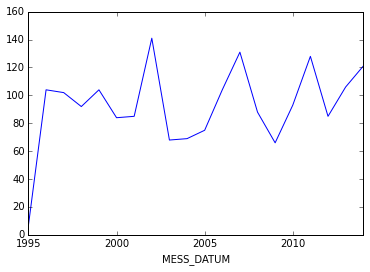

In [14]:
df_stations_flat = df_stations.stack().reset_index()
df_stations_flat_sr = df_stations_flat[df_stations_flat[0] >= 17]
df_stations_flat_sr.groupby(df_stations_flat_sr.MESS_DATUM.dt.year).size().plot()

In [15]:
df_stations_flat_sr.groupby(df_stations_flat_sr.MESS_DATUM.dt.year)[0].agg([np.median, len])

,median,len
MESS_DATUM,,
1995,40.00,7.0
1996,99.00,104.0
1997,22.75,102.0
1998,55.50,92.0
1999,27.10,104.0
2000,27.80,84.0
2001,22.90,85.0
2002,21.10,141.0
2003,21.65,68.0


In [16]:
df_stations_flat_sr[(df_stations_flat_sr.STATIONS_ID == 1766)]

,MESS_DATUM,STATIONS_ID,0
752001,1996-06-21 03:00:00,1766,99.0
809557,1996-07-12 16:00:00,1766,26.5
892585,1996-08-12 14:00:00,1766,19.2
1033216,1996-10-04 03:00:00,1766,99.0
1318387,1997-01-18 04:00:00,1766,99.0
1400908,1997-02-17 12:00:00,1766,99.0
1548824,1997-04-12 05:00:00,1766,99.0
1742560,1997-06-21 09:00:00,1766,99.0
2607183,1998-05-01 08:00:00,1766,99.0
2607523,1998-05-01 11:00:00,1766,99.0


In [17]:
stations[stations.sid == 2638]

,Bundesland,Stations_id,Stationshoehe,Stationsname,bis_datum,geoBreite,geoLaenge,von_datum,sid,lat,lng,height
486,Baden-Württemberg,02638,973,Klippeneck,2016-03-05,48.1054,8.7549,1949-01-01,2638,48.1054,8.7549,973


In [18]:
constant_stations[constant_stations.Stationsname.str.contains('Münster')]

,Bundesland,Stations_id,Stationshoehe,Stationsname,bis_datum,geoBreite,geoLaenge,von_datum,sid,lat,lng,height
341,Nordrhein-Westfalen,01766,48,Münster/Osnabrück,2016-03-05,52.1344,7.6969,1989-10-01,1766,52.1344,7.6969,48


### Looking for heavy rain

In [19]:
station_values = df.groupby(['MESS_DATUM', 'STATIONS_ID']).NIEDERSCHLAGSHOEHE.sum().unstack()
station_values.head()

STATIONS_ID,20,44,53,71,73,78,87,91,103,118,...,13713,13715,13716,13774,13777,14157,15000,15003,15207,15444
MESS_DATUM,,,,,,,,,,,,,,,,,,,,,
1995-09-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1995-09-01 01:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1995-09-01 02:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1995-09-01 03:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1995-09-01 04:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


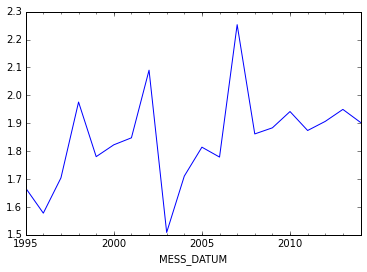

In [20]:
hourly_99th_year = station_values.resample('1A').apply(lambda x: x.quantile(q=0.99))
hourly_99th_year.mean(1).plot()

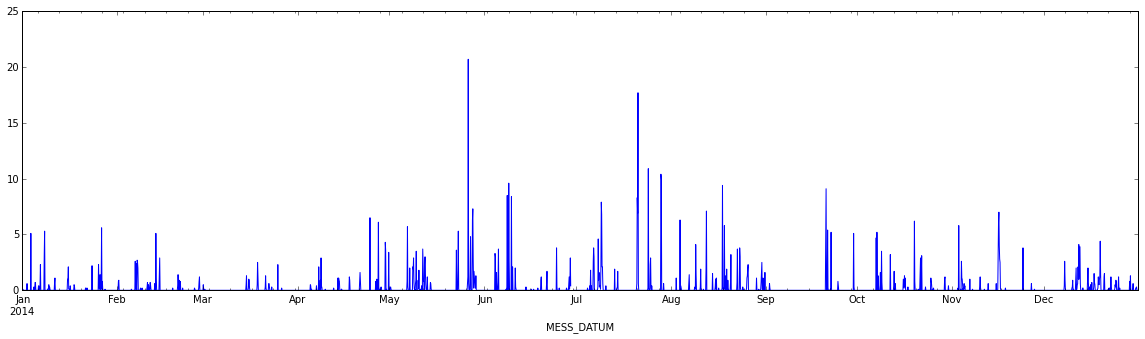

In [21]:
plt.figure(figsize=(20, 5))
station_1766_2014 = df[(df.STATIONS_ID == 1766) & (df.MESS_DATUM.dt.year == 2014)]
station_1766_2014.set_index('MESS_DATUM').NIEDERSCHLAGSHOEHE.resample('3H').sum().plot()

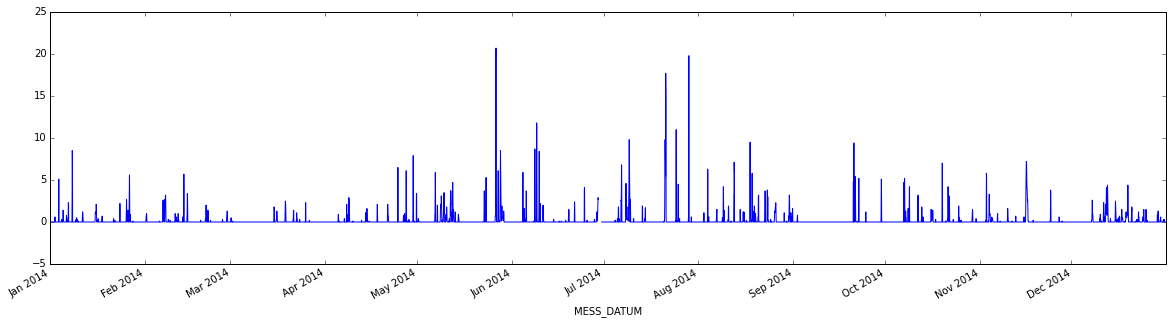

In [23]:
plt.figure(figsize=(20, 5))
station_1766_2014.set_index('MESS_DATUM').NIEDERSCHLAGSHOEHE.rolling(window=3, min_periods=3).sum().plot()

In [24]:
# .NIEDERSCHLAGSHOEHE.resample('3H', how=np.sum)
df_complete_hsum = df_complete.groupby(['MESS_DATUM', 'STATIONS_ID']).NIEDERSCHLAGSHOEHE.sum().unstack()

In [25]:
HOURLY_THRESHOLD = 17
threshold_counter = lambda x: len(x[x[0] >= HOURLY_THRESHOLD])
df_hsum = df_complete_hsum.stack().reset_index()
heavy_rain_count = df_hsum.groupby('STATIONS_ID').apply(threshold_counter)
heavy_rain_count.head()

STATIONS_ID
44      5
164    15
183     8
198     7
222    20
dtype: int64

In [26]:
heavy_rain_count.sort_values(ascending=False).head(10)

STATIONS_ID
2290    37
4024    36
5546    35
5779    32
5347    32
5397    27
1303    26
2559    25
840     25
2667    24
dtype: int64

/Users/sw/.virtualenvs/notebook3/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


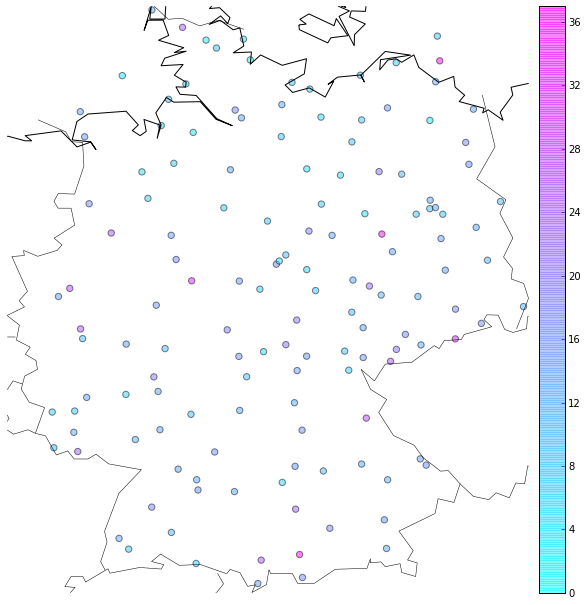

In [27]:
plot_map(heavy_rain_count.reset_index().merge(stations, left_on='STATIONS_ID', right_on='sid'), 0)

In [28]:
df_hsum_year = df_hsum.groupby([df_hsum.MESS_DATUM.dt.year, 'STATIONS_ID']).apply(threshold_counter)

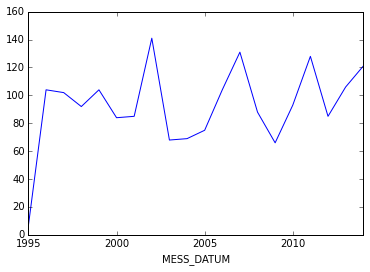

In [29]:
df_hsum_year.unstack().sum(1).plot()

### Vis Export

In [30]:
df_15 = df[df.NIEDERSCHLAGSHOEHE >= 15]
len(df_15)

10835

In [31]:
df_ex = df_15.merge(stations[['sid', 'lat', 'lng']], left_on='STATIONS_ID', right_on='sid', how='left')

In [32]:
df_ex.head()

,Unnamed: 0,STATIONS_ID,MESS_DATUM,QUALITAETS_NIVEAU,NIEDERSCHLAG_GEFALLEN_IND,NIEDERSCHLAGSHOEHE,NIEDERSCHLAGSFORM,eor,sid,lat,lng
0,8368,20,2005-07-29 19:00:00,3.0,1.0,23.4,6.0,eor,20,48.922,9.9129
1,9388,20,2005-09-10 07:00:00,3.0,1.0,16.9,6.0,eor,20,48.922,9.9129
2,17106,20,2006-07-28 22:00:00,3.0,1.0,18.6,6.0,eor,20,48.922,9.9129
3,17437,20,2006-08-11 17:00:00,3.0,1.0,16.6,6.0,eor,20,48.922,9.9129
4,26117,20,2007-08-08 09:00:00,3.0,1.0,16.9,NaN,eor,20,48.922,9.9129


- Wetterstation (Name/ID)
- Lat/Long-Koordinaten
- Niederschlagsmenge (bzw. -höhe) >= 15mm/h
- Zeitpunkt

In [33]:
df_ex[['STATIONS_ID', 'lat', 'lng', 'NIEDERSCHLAGSHOEHE', 'MESS_DATUM']].to_csv('stern_export_hourly_15.csv', index=False)

In [34]:
df_r = pd.read_csv('stern_export_hourly_15.csv', parse_dates=['MESS_DATUM'])
df_r.head()

,STATIONS_ID,lat,lng,NIEDERSCHLAGSHOEHE,MESS_DATUM
0,20,48.922,9.9129,23.4,2005-07-29 19:00:00
1,20,48.922,9.9129,16.9,2005-09-10 07:00:00
2,20,48.922,9.9129,18.6,2006-07-28 22:00:00
3,20,48.922,9.9129,16.6,2006-08-11 17:00:00
4,20,48.922,9.9129,16.9,2007-08-08 09:00:00


In [35]:
len(df_r[df_r.MESS_DATUM.dt.year == 2012].STATIONS_ID.value_counts())

521

In [36]:
len(df_r[df_r.MESS_DATUM.dt.year == 1998].STATIONS_ID.value_counts())

70

In [37]:
df_r['MESS_DATUM'].describe()

count                   10835
unique                   5319
top       2013-06-20 20:00:00
freq                       23
first     1995-09-13 20:00:00
last      2014-12-29 20:00:00
Name: MESS_DATUM, dtype: object

In [38]:
min_date = df_r['MESS_DATUM'].min()
max_date = df_r['MESS_DATUM'].max()
min_date, max_date

(Timestamp('1995-09-13 20:00:00'), Timestamp('2014-12-29 20:00:00'))

### Events per station

In [46]:
from datetime import date, timedelta
from dateutil.relativedelta import relativedelta

THRESHOLD = 15

def get_events_stations(df, stations):
    end_date = date(2015, 1, 1)
    current_date = date(1995, 9, 1)
    while current_date <= end_date:
        current_date_start = current_date
        current_date_end = current_date_start + relativedelta(months=1)
        week_events = df[(df.NIEDERSCHLAGSHOEHE >= THRESHOLD) & (df.MESS_DATUM >= current_date_start) & (df.MESS_DATUM < current_date_end)].groupby('STATIONS_ID').size()
        part_stations = stations[(stations.von_datum <= current_date_end) & (stations.bis_datum >= current_date_start)][['lat', 'lng', 'sid']]
        yield {
            'num_events': len(week_events),
            'num_stations': len(part_stations),
            'date': current_date
        }
        current_date = current_date_end
#         print(current_date)

events_per_station = pd.DataFrame(get_events_stations(df, stations))
events_per_station.head()

,date,num_events,num_stations
0,1995-09-01,2,234
1,1995-10-01,0,234
2,1995-11-01,1,234
3,1995-12-01,1,234
4,1996-01-01,0,234


In [47]:
events_per_station['ratio'] = events_per_station['num_events'] / events_per_station['num_stations']
events_per_station['date'] = pd.to_datetime(events_per_station['date'])

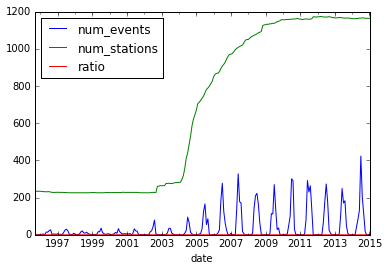

In [48]:
events_df = events_per_station.set_index('date')
events_df.plot()

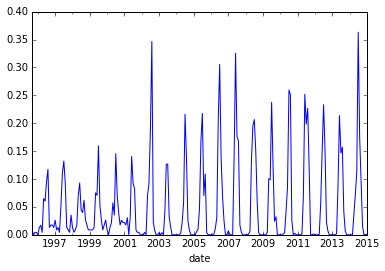

In [49]:
events_df['ratio'].plot()

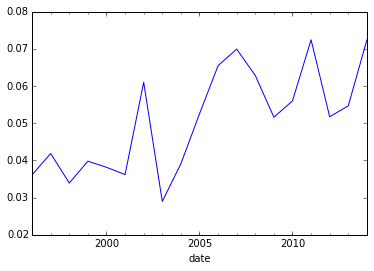

In [50]:
events_df.resample('1A')['ratio'].mean().iloc[1:-1].plot()